**Using Clay embeddings to detect Earthquake**

In [ ]:
#git clone https://github.com/Clay-foundation/model  #Need to run this for the first time

In [ ]:
# pip install torchgeo[all]
# pip install git+https://github.com/microsoft/torchgeo.git   #Use this to be able to access the QuakeSet dataset

In [20]:
#importing the required modules

import torchgeo
import torchgeo.datasets as datasets
import sys
import torch
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


sys.path.append("model/")

from src.model import ClayMAEModule

In [3]:
torchgeo.__version__ #check torchgeo version

'0.6.0.dev0'

**Downloading the QuakeSet dataset**

@misc{cambrin2024quakesetdatasetlowresourcemodels,
      title={QuakeSet: A Dataset and Low-Resource Models to Monitor Earthquakes through Sentinel-1}, 
      author={Daniele Rege Cambrin and Paolo Garza},
      year={2024},
      eprint={2403.18116},
      archivePrefix={arXiv},
      primaryClass={cs.CV},
      url={https://arxiv.org/abs/2403.18116}, 
}

In [4]:
#We download the QuakeSet dataset available in torchgeo.
#We will work with the "train" split of the data only to show the workflow

train_ds = datasets.QuakeSet(split="train",download=False) #Change download to True to download first time

In [5]:
#val_ds = datasets.QuakeSet(split="val",download=False) #Can download and use other splits such "val","test"

In [6]:
#Checking the Sentinel-1 imagery size. 

#Each sample consists of pre and post event data with two channels - vv and vh of Sentinel-1

train_ds[0]["image"].shape

torch.Size([4, 512, 512])

In [7]:
#Download Clay-1 model

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "https://clay-model-ckpt.s3.amazonaws.com/v0.5.7/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt"
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path="model/configs/metadata.yaml", shuffle=False, mask_ratio=0
)
model.eval()

model = model.to(device)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
#Dataset class to use for loading the data

class EarthQuakeDataset:
    def __init__(self,ds):
        self.ds = ds
    
    def __len__(self):
        return len(self.ds)

    def __getitem__(self,idx):
        pre_image = self.ds[idx]["image"][:2,:,:]  #First two images are Sentinel-1 images (vv & vh band) of pre-event 
        post_image = self.ds[idx]["image"][2:,:,:] #Last two images are Sentinel-1 images (vv & vh band) of post-event
        label = self.ds[idx]["label"]

        sample = {
            "pixels1": pre_image,  # 2 x 512 x 512
            "pixels2": post_image, # 2 x 512 x 512
            "time": torch.zeros(4),  # Placeholder for time information
            "latlon": torch.zeros(4),  # Placeholder for latlon information
            "label":label
        }

       
        return sample


#Construct training dataset object
train_dataset = EarthQuakeDataset(train_ds)

#validation_dataset = EarthQuakeDataset(val_ds)

In [ ]:
#Dataloaders from dataset
train_dl = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True,generator=torch.Generator(device=device))
#val_dl = torch.utils.data.DataLoader(validation_dataset,batch_size=32,shuffle=False,generator=torch.Generator(device=device))

In [17]:
#Generate embeddings for the data

from tqdm.auto import tqdm

gsd =  torch.tensor(10, device=device)  #Ground sampling distance for Sentinel-1
waves = torch.tensor([3.5,4.0], device=device)  #wavelengths for Sentinel-1

embeddings1 = []
embeddings2 = []
target = []

for bid,batch in enumerate(tqdm(train_dl)):
   
    datacube1 = {
        "pixels": batch["pixels1"].to(device),
        "time":batch["time"].to(device),
        "latlon":batch["latlon"].to(device),
        "gsd": gsd,
        "waves": waves,
    }

    datacube2 = {
        "pixels": batch["pixels2"].to(device),
        "time":batch["time"].to(device),
        "latlon":batch["latlon"].to(device),
        "gsd": gsd,
        "waves": waves,
    }

    with torch.no_grad():
        unmsk_patch1, unmsk_idx1, msk_idx1, msk_matrix1 = model.model.encoder(datacube1)
        unmsk_patch2, unmsk_idx2, msk_idx2, msk_matrix2 = model.model.encoder(datacube2)

    emb1 = unmsk_patch1[:, 0, :].cpu().numpy()
    emb2 = unmsk_patch2[:, 0, :].cpu().numpy()

    embeddings1.append(emb1)
    embeddings2.append(emb2)
    target.append(batch["label"].cpu().numpy())


  0%|          | 0/284 [00:00<?, ?it/s]

In [28]:
#Saving embeddings and ground truth (label) data

np.save("train_emb.npy",np.concatenate((np.concatenate(embeddings1),np.concatenate(embeddings2)),axis=1))
np.save("train_label.npy",np.concatenate(target))

In [29]:
#Load the saved embeddings and ground truth (labels)

X = np.load("train_emb.npy")
y = np.load("train_label.npy")

X.shape,y.shape  #Check dimensions. The embeddings have a size of 768. Since we have pre-event and post-event image and we concatenate the embeddings so the dimension is 768 x 2 

((2266, 1536), (2266,))

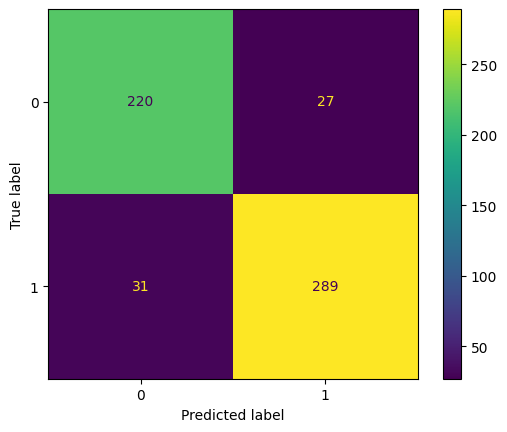

In [32]:
#Train a RandomForestClassifier on the embeddings

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)  #Split the data into two parts - one for training and other for validation 

clf = RandomForestClassifier() #Instantiate a RandomForestClassifier
clf.fit(X_train, y_train) #Train on embeddings
predictions = clf.predict(X_test) #Generate predictions

#Confusion matrix
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [37]:
#check F1-score which is the metric for the competition which uses this data - "ECML-PKDD 2024 - SMAC: Seismic Monitoring and Analysis Challenge" https://www.codabench.org/competitions/2222/#/pages-tab had F1-score upward of 0.908 with training Deep Learning Models

from sklearn.metrics import f1_score

score = f1_score(y_test,predictions)

print("F1 score: ",score)



F1 score:  0.9088050314465408
